## Imports

In [43]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly 
import plotly.express as px
import seaborn as sns

from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import StandardScaler

Import data

In [2]:
filepath = '../data/healthcare-dataset-stroke-data.csv'
data_all = pd.read_csv(filepath)
data_all=data_all.drop('id', axis=1)
data_all.shape

(5110, 11)

remove samples with age under 60 since focus is on elderly

In [3]:
data = data_all.drop(data_all[data_all.age < 60].index)
# for comparison with all ages
# data = data_all.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1376 entries, 0 to 5106
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             1376 non-null   object 
 1   age                1376 non-null   float64
 2   hypertension       1376 non-null   int64  
 3   heart_disease      1376 non-null   int64  
 4   ever_married       1376 non-null   object 
 5   work_type          1376 non-null   object 
 6   Residence_type     1376 non-null   object 
 7   avg_glucose_level  1376 non-null   float64
 8   bmi                1285 non-null   float64
 9   smoking_status     1376 non-null   object 
 10  stroke             1376 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 129.0+ KB


# Visualization

## Basic Statistics

In [42]:
stroke = data['stroke']
print(f'Stroke: {round(stroke.value_counts(normalize=True)[1]*100,2)}% ({stroke.value_counts()[1]} patients)')
print(f'No stroke: {round(stroke.value_counts(normalize=True)[0]*100,2)}% ({stroke.value_counts()[0]} patients)')

print("\nFor comparison: ratio for all age groups:")
stroke_all = data_all['stroke']
print(f'Stroke: {round(stroke_all.value_counts(normalize=True)[1]*100,2)}% ({stroke_all.value_counts()[1]} patients)')
print(f'No stroke: {round(stroke_all.value_counts(normalize=True)[0]*100,2)}% ({stroke_all.value_counts()[0]} patients)')



# fig = px.histogram(data, x="stroke", title='Stroke', width=400, height=400)
# fig.show()

fig = px.pie(data, width=500, names='stroke',title="Stroke class distribution", labels={
                     "stroke": "Had stroke?"
                 })
fig.show()
fig.write_image("../data/stroke_class_distribution.png", engine='kaleido')


Stroke: 13.15% (181 patients)
No stroke: 86.85% (1195 patients)

For comparison: ratio for all age groups:
Stroke: 4.87% (249 patients)
No stroke: 95.13% (4861 patients)


We obviously have imbalanced classes
This can lead to problems in some models and metrics (e.g. accuracy). Solve this in classification by using ROC curve and/or stratified k-fold for train/test split (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)

## Feature Evaluation
Next we will look at the different features more closely. For that, we will distinguish between the numerical and the categorical features

In [5]:
categorical = ['gender', 'hypertension', 'heart_disease', 'ever_married',
'work_type', 'Residence_type', 'smoking_status']

numerical = ['age','avg_glucose_level', 'bmi']

### Numerical

our numerical features are age, avg_glucose_level and bmi

In [6]:
data[numerical].describe()

,age,avg_glucose_level,bmi
count,1376.000000,1376.000000,1285.000000
mean,70.904070,121.898416,29.969339
std,7.027703,58.166132,6.015558
min,60.000000,55.230000,11.300000
25%,64.000000,79.142500,26.100000
50%,71.000000,96.965000,29.200000
75%,78.000000,174.457500,33.500000
max,82.000000,271.740000,60.200000


In [7]:
data[numerical].skew()

age                 -0.007964
avg_glucose_level    0.901834
bmi                  0.791880
dtype: float64

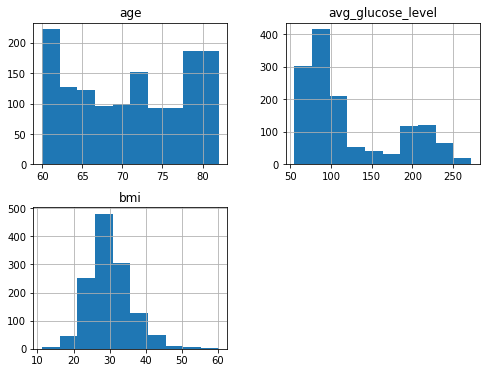

In [8]:
data[numerical].hist(figsize=(8,6));

From the numbers above, we see that our numerical values are measured in different scales. Some ML models have difficulties with that. Therefore we have to scale the data.

From the skewness value, we can also see that our data is slightly asymmetric. To make the data more gaussian-like, we will use a power transformation.

We will deal with this later.

### Categorical
our categorical features are gender, hypertension, heart_disease, ever_married, work_type, Residence_type and smoking_status

Below, we plot the distribution of the categorical features and how they influence stroke probability

In [9]:
# hypertension
plot = px.histogram(data, x="hypertension", color="stroke",width=400, height=400, title="Hypertension and Stroke", labels={
                     "hypertension": "Hypertension",
                     "stroke": "Had stroke?"
                 },)
plot.show()
print()
print (f'Stroke probability with hypertension: {round(data[data["hypertension"]==1]["stroke"].mean()*100,2)} %')
print (f'Stroke probability without hypertension: {round(data[data["hypertension"]==0]["stroke"].mean()*100,2)} %')
print (f'Person with hypertension is {round((data[data["hypertension"]==1]["stroke"].mean()*100)/(data[data["hypertension"]==0]["stroke"].mean()*100),2)} times more likely to get a stroke')

# gender
plot = px.histogram(data, x="gender", color="stroke",width=400, height=400, title="Gender and Stroke", labels={
                     "gender": "Gender",
                     "stroke": "Had stroke?"
                 },)
plot.show()
print()
print (f'Stroke probability for male: {round(data[data["gender"]=="Female"]["stroke"].mean()*100,2)} %')
print (f'Stroke probability for female: {round(data[data["gender"]=="Female"]["stroke"].mean()*100,2)} %')
print('No significant difference between male and female')

# heart disease
plot = px.histogram(data, x="heart_disease", color="stroke",width=400, height=400, title="Heart disease and Stroke", labels={
                     "gender": "Gender",
                     "stroke": "Had stroke?"
                 },)
plot.show()
print()
print (f'Stroke probability with heart disease: {round(data[data["heart_disease"]==1]["stroke"].mean()*100,2)} %')
print (f'Stroke probability without heart disease: {round(data[data["heart_disease"]==0]["stroke"].mean()*100,2)} %')
print (f'Person with heart disease is {round((data[data["heart_disease"]==1]["stroke"].mean()*100)/(data[data["heart_disease"]==0]["stroke"].mean()*100),2)} times more likely to get a stroke')

# married
plot = px.histogram(data, x="ever_married", color="stroke",width=400, height=400, title="Marriage and Stroke", labels={
                     "ever_married": "Ever married?",
                     "stroke": "Had stroke?"
                 },)
plot.show()
print()
print (f'Stroke probability when ever married: {round(data[data["ever_married"]=="Yes"]["stroke"].mean()*100,2)} %')
print (f'Stroke probability without ever being married: {round(data[data["ever_married"]=="No"]["stroke"].mean()*100,2)} %')
print (f'A married person is {round((data[data["ever_married"]=="Yes"]["stroke"].mean()*100)/(data[data["ever_married"]=="No"]["stroke"].mean()*100), 2)} times more likely to get a stroke')
# interesting, for all age groups its the other way round. Older people seem to have less stressfull mariages

# work type
plot = px.histogram(data, x="work_type", color="stroke",width=500, height=400, title="Work Type and Stroke", labels={
                     "work_type": "Work Type",
                     "stroke": "Had stroke?"
                 },)
plot.show()
print()
print (f'Stroke probability when private job: {round(data[data["work_type"]=="Private"]["stroke"].mean()*100,2)} %')
print (f'Stroke probability when self employed: {round(data[data["work_type"]=="Self-employed"]["stroke"].mean()*100,2)} %')
print (f'Stroke probability when government job: {round(data[data["work_type"]=="Govt_job"]["stroke"].mean()*100,2)} %')

# Residence
plot = px.histogram(data, x="Residence_type", color="stroke",width=400, height=400, title="Residence Type and Stroke", labels={
                     "Residence_type": "Residence type?",
                     "stroke": "Had stroke?"
                 },)
plot.show()
print()
print (f'Stroke probability when living in urban area: {round(data[data["Residence_type"]=="Urban"]["stroke"].mean()*100,2)} %')
print (f'Stroke probability when living in rural area: {round(data[data["Residence_type"]=="Rural"]["stroke"].mean()*100,2)} %')
print (f'A person living in an urban area is {round((data[data["Residence_type"]=="Urban"]["stroke"].mean()*100)/(data[data["Residence_type"]=="Rural"]["stroke"].mean()*100), 2)} times more likely to get a stroke')

# Smoking
plot = px.histogram(data, x="smoking_status", color="stroke",width=500, height=400, title="Smoking Habits and Stroke", labels={
                     "smoking_status": "Smoking?",
                     "stroke": "Had stroke?"
                 },)
plot.show()
print()
print (f'Stroke probability when formerly smoked: {round(data[data["smoking_status"]=="formerly smoked"]["stroke"].mean()*100,2)} %')
print (f'Stroke probability when never smoked: {round(data[data["smoking_status"]=="never smoked"]["stroke"].mean()*100,2)} %')
print (f'Stroke probability when smokes: {round(data[data["smoking_status"]=="smokes"]["stroke"].mean()*100,2)} %')
# surprisingly no impact





Stroke probability with hypertension: 17.91 %
Stroke probability without hypertension: 11.85 %
Person with hypertension is 1.51 times more likely to get a stroke



Stroke probability for male: 12.61 %
Stroke probability for female: 12.61 %
No significant difference between male and female



Stroke probability with heart disease: 20.09 %
Stroke probability without heart disease: 11.88 %
Person with heart disease is 1.69 times more likely to get a stroke



Stroke probability when ever married: 12.61 %
Stroke probability without ever being married: 19.63 %
A married person is 0.64 times more likely to get a stroke



Stroke probability when private job: 14.11 %
Stroke probability when self employed: 12.2 %
Stroke probability when government job: 11.86 %



Stroke probability when living in urban area: 14.0 %
Stroke probability when living in rural area: 12.26 %
A person living in an urban area is 1.14 times more likely to get a stroke



Stroke probability when formerly smoked: 13.92 %
Stroke probability when never smoked: 13.22 %
Stroke probability when smokes: 13.09 %


### Dependency between categorical features and stroke:

In [10]:
from sklearn.metrics import mutual_info_score
def cat_mut_inf(series):
    return mutual_info_score(series, data['stroke']) 

data_cat = data[categorical].apply(cat_mut_inf) 
data_cat = data_cat.sort_values(ascending=False).to_frame(name='mutual_info_score') 
data_cat

,mutual_info_score
heart_disease,0.003511
hypertension,0.002541
ever_married,0.001388
work_type,0.000448
Residence_type,0.000334
smoking_status,0.000201
gender,0.000180


In [26]:
fig = px.bar(data_cat, width=900,title="Correlation between Features and Stroke", y="mutual_info_score", labels={
                     "mutual_info_score": "Mutual Information Score",
                    "index": "Feature"
                 })
fig.show()
fig.write_image("../data/categorical_correlation_bar.png", engine='kaleido')

The low mutual information score shows a very low dependence between our categorical features  and the target variable. For prediction we therefore have to rely mostly on the numerical features

### Dependency between numerical features and stroke:

In [12]:
numericals_corr = data[['age','avg_glucose_level','bmi','stroke']].corr()
numericals_corr

,age,avg_glucose_level,bmi,stroke
age,1.000000,0.030870,-0.195958,0.172429
avg_glucose_level,0.030870,1.000000,0.221962,0.100605
bmi,-0.195958,0.221962,1.000000,-0.030994
stroke,0.172429,0.100605,-0.030994,1.000000


In [27]:
fig = px.imshow(numericals_corr.round(2), width=700,title="Correlation between numerical features", labels=dict(color="Correlation"), color_continuous_scale='Sunset', text_auto=True)
fig.show()
fig.write_image("../data/numerical_correlation_heatmap.png", engine='kaleido')

The correlation between numerical features and target variable is also rather low. The feature with the highest correlation to stroke is age with a positive relationship of 0.17. The feature with the lowest correlation is bmi.

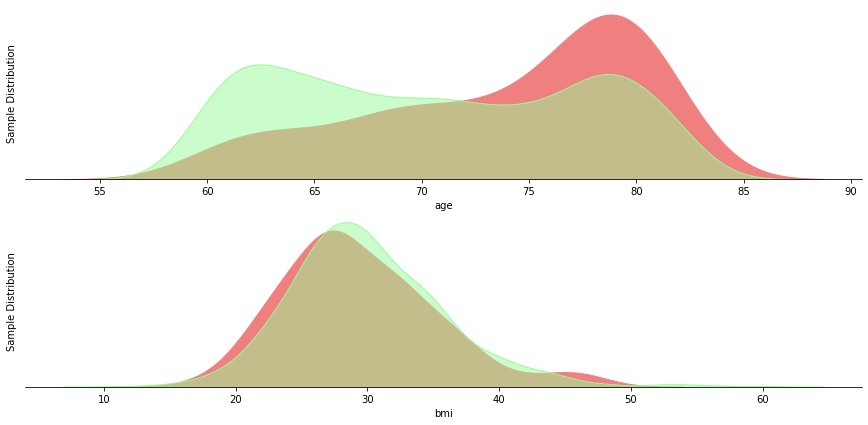

In [78]:
fig=plt.figure(figsize=(15,7),facecolor='white')

ax=[None for i in range(2)]
gs=fig.add_gridspec(2,1)
# gs.update(wspace=0, hspace=0.8)

ax[0]=fig.add_subplot(gs[0,0])
ax[1]=fig.add_subplot(gs[1,0])

# ax[0].text(-20,0.04,'Relationship between age and stroke',fontsize=21,fontweight='bold', fontfamily='monospace')
# ax[0].text(-20,0.035,'The older a person is, the more likely he/she has a stroke',fontsize=16,fontweight='light', fontfamily='monospace')
# ax[1].text(-30,0.023,'Relationship between average glucose level and stroke',fontsize=21,fontweight='bold', fontfamily='monospace')
# ax[1].text(-30,0.0207,'From this graph, there is no clear relationship between avg_glucose_level and stroke',fontsize=16,fontweight='light', fontfamily='monospace')

sns.kdeplot(data=data[data.stroke==1],x='age',ax=ax[0],shade=True,color='lightcoral',alpha=1)
sns.kdeplot(data=data[data.stroke==0],x='age',ax=ax[0],shade=True,color='palegreen',alpha=0.5)
sns.kdeplot(data=data[data.stroke==1],x='bmi',ax=ax[1],shade=True,color='lightcoral',alpha=1)
sns.kdeplot(data=data[data.stroke==0],x='bmi',ax=ax[1],shade=True,color='palegreen',alpha=0.5)

for i in range(2):
    ax[i].set_yticklabels('')
    ax[i].set_ylabel('Sample Distribution')
    ax[i].tick_params(axis='y',length=0)
    
    for direction in ['top','right','left']:
        ax[i].spines[direction].set_visible(False)

fig.savefig("../data/numerical_correlation_age_bmi.png") 

# Preparing the Dataset

## Missing values

next step is to find missing values and replace them

In [16]:
nans = data.isnull().sum().sort_values(ascending=False)
nans

bmi                  91
stroke                0
smoking_status        0
avg_glucose_level     0
Residence_type        0
work_type             0
ever_married          0
heart_disease         0
hypertension          0
age                   0
gender                0
dtype: int64

We see that 91 (~6.7%) of our bmi values are missing.
(Note: this only detects missing numeric values not categorical ones like "Unknown")

To solve this, we replace missing values using the mean along the column.

In [17]:
prep_data = data.copy()

prep_data['bmi'] = prep_data['bmi'].fillna(prep_data['bmi'].mean())
prep_data['bmi'].isnull().sum()

0

## Categorical values

Since most ML models dont work well with categorical features, we will now convert our categorical features into one hot encoded numbers

In [18]:

prep_data['gender'] = pd.factorize(prep_data['gender'])[0]
prep_data['ever_married'] = pd.factorize(prep_data['ever_married'])[0]
prep_data['work_type'] = pd.factorize(prep_data['work_type'])[0]
prep_data['Residence_type'] = pd.factorize(prep_data['Residence_type'])[0]
prep_data['smoking_status'] = pd.factorize(prep_data['smoking_status'])[0]

prep_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1376 entries, 0 to 5106
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             1376 non-null   int64  
 1   age                1376 non-null   float64
 2   hypertension       1376 non-null   int64  
 3   heart_disease      1376 non-null   int64  
 4   ever_married       1376 non-null   int64  
 5   work_type          1376 non-null   int64  
 6   Residence_type     1376 non-null   int64  
 7   avg_glucose_level  1376 non-null   float64
 8   bmi                1376 non-null   float64
 9   smoking_status     1376 non-null   int64  
 10  stroke             1376 non-null   int64  
dtypes: float64(3), int64(8)
memory usage: 129.0 KB


## (Power transformation)
use e.g. yeo-johnson transformation to make data more gaussian
(left out, probably not necessary since skewness is low)

## Scaling

We use the sklearn to scale the dataset to zero mean and unit variance

In [19]:
numerical_columns = prep_data[numerical]

scaler = StandardScaler().fit(numerical_columns.values)
numerical_columns = scaler.transform(numerical_columns.values)

prep_data[numerical] = numerical_columns

prep_data.describe()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,1376.000000,1.376000e+03,1376.000000,1376.000000,1376.000000,1376.000000,1376.000000,1.376000e+03,1.376000e+03,1376.000000,1376.000000
mean,0.582122,9.294890e-16,0.215116,0.155523,0.077762,0.615552,0.486192,-7.229359e-17,5.150918e-16,1.184593,0.131541
std,0.493389,1.000364e+00,0.411052,0.362535,0.267893,0.720418,0.499991,1.000364e+00,1.000364e+00,0.996398,0.338114
min,0.000000,-1.552148e+00,0.000000,0.000000,0.000000,0.000000,0.000000,-1.146589e+00,-3.212770e+00,0.000000,0.000000
25%,0.000000,-9.827649e-01,0.000000,0.000000,0.000000,0.000000,0.000000,-7.353327e-01,-6.314494e-01,0.000000,0.000000
50%,1.000000,1.365526e-02,0.000000,0.000000,0.000000,0.000000,0.000000,-4.288145e-01,-4.634995e-02,1.000000,0.000000
75%,1.000000,1.010075e+00,0.000000,0.000000,0.000000,1.000000,1.000000,9.039314e-01,5.258429e-01,2.000000,0.000000
max,1.000000,1.579458e+00,1.000000,1.000000,1.000000,2.000000,1.000000,2.577033e+00,5.202336e+00,3.000000,1.000000


We see that now our numerical features have a mean of 0 and std of 1

## Export preprocessed data
In case we want to use the preprocessed dataset outside of this notebook, we export it to a file

In [20]:
prep_data.to_csv('../data/preprocessed_data.csv', index=False)

## Sources

- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mutual_info_score.html
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html
- https://plotly.com/python/plotly-express/
- https://www.kaggle.com/fedesoriano/stroke-prediction-dataset
- https://www.kaggle.com/kaanboke/beginner-friendly-end-to-end-ml-project-enjoy/notebook


## Quick Classification test
Just as a first impression, perform a simple log regression on the preprocessed dataset

(**use stratified k fold to balance data!**)

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
# X = 
y = prep_data['stroke']
X = prep_data.iloc[:,:-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf = LogisticRegression(random_state=0).fit(X, y)
clf.predict(X)
clf.score(X, y)

0.8677325581395349